# CORO Project - Held \& Karp algorithm

## Joseph ELANG, François LEFOULON, Théophile RAGEAU, Baptiste SIGNOLLE

**A REDIGER : Note sur l'utilisation d'un notebook, nbviewer, conversion en .jl, jupyter et jupyter lab**

**Requirements : Version julia et des modules, un project.toml etc PKG blabla**

The Held and Karp algorithm as described in "The traveling-salesman problem and minimum spanning trees" (1969) tackles the STSP (Symetric Traveling Salesman Problem) using the concept of 1-tree, which consist for $n$ vertices numbered from $1$ to $n$ of a spanning tree for the vertices $2$ to $n$, to which is connected the vertex $1$ such that it have a degree equals to $2$.

In this paper several LP of the STSP are derived, and the authors show how they are related to one another. Then resolution methods are presented.

The core idea behind this work is that instead of relaxing the connectivity constraint as seen in the polyhedral approach, Held and Karp chose to relax the degree constraints using the concept of 1-tree.

Here we present our attemps to solve the STSP with column generation, and more generally the techniques presented in Held and Karp's paper, as shown in John E. Mitchell's slides.

We ran into some troubles while working on this project, mostly because we hardly saw a link between column generation, JuMP and the algorithm described in J.E. Mitchell's slides. In these the only things which seems to be involved are a greedy algorithm (Kruskal's for example) to solve a spanning tree problem, basic minimum finding techniques to connect vertex 1 and a loop to start again until a cycle is found (updating the weights between each iteration).

We will go through the following
* STSP using column generation
* Held and Karp algorithm - attempt 1
* Held and Karp algorithm - attempt 2
* The Held and Karp algorithm - dynamical programming

### Modules and useful functions

In [1]:
using LinearAlgebra # Basic algebra structures & functions
using JuMP          # Modeling language
using Cbc           # MIP solver
using LightGraphs   # Efficient graph structures & functions
using GraphPlot     # Graph visualization
using Combinatorics # Combinatorials

println("Modules loaded")

Modules loaded


In [2]:
function checkTermination(m, verbose = true)
    if !( 
                ( termination_status(m) == MOI.OPTIMAL ) || 
                ( termination_status(m) == MOI.TIME_LIMIT && has_values(m) ) 
            )
        
        if verbose
            println(termination_status(m))
            println(termination_status(m))
            println(has_values(m))
            println(m)
        end
        
        error("Couldn't connect vertex 1 (PLNE failed).")
    end
end

checkTermination (generic function with 2 methods)

In [3]:
# Graph display function
# S and W are assumed to be square matrices
# S the adjacency matrix of a graph
# W the weights of its edges
function display_S(S, W = nothing)
    edgelabel = []
    n = size(S,1)
    if W != nothing
        m = size(W, 1)
        if m != n
            error("display_S : S and W don't match ; S is of size ", n, ", W of size ", m)
        end
        for i in 1:n, j in i:n
            if X[i, j] == 1
                push!(edgelabel, W[i, j])
            end
        end
    end
    display(gplot(Graph(S), nodelabel=1:n, edgelabel = edgelabel))
end

display_S (generic function with 2 methods)

## Data to test our results

The data we will be using is extracted from [John E. Mitchell's slides](http://eaton.math.rpi.edu/faculty/Mitchell/courses/matp6620/notesMATP6620/lecture22/22A_heldkarpbeamer.pdf).

However on such small graphs column generation techniques will not show their full potential, as these methods aim to tackle large scale problems.

![Example weights](./images/example_graph.png)
![Example solution](./images/example_graph_solution.png)
![Exercise weights](./images/exercise_graph.png)

In [4]:
example = [
    0   8  4 15 15  3 ;
    8   0  5 15  2 15 ;
    4   5  0  6 15 15 ;
    15 15  6  0  5  3 ;
    15  2 15  5  0  4 ;
    3  15 15  3  4  0
]

exercise = [
     0 15  0  0 15 15 15 ;
    15  0  1 15  0 15  1 ;
     0  1  0 15 15 15  1 ;
     0 15 15  0  1  1 15 ;
    15  0 15  1  0  1 15 ;
    15 15 15  1  1  0  0 ;
    15  1  1 15 15  0  0 ;
]

println("Weight matrices initialized")

Weight matrices initialized


## STSP using column generation

The STSP can be written as

$$\begin{array}{r l}
\min & \sum_{e\in E} c_e x_e \\
\text{s.t.}
& \sum_{e\in \delta(i)} x_e = 2 \quad (i\in N) \\
& x \in X^1
\end{array}$$

$N$ is the set of nodes  
$\delta(i)$ the set of edges incident to $i$  
$x_e$ indicator variable for edge $e$  
$X^1$ set of indicator vectors of 1-trees

A 1-tree is a subset $E' \subset E$ of edges of which exactly two are incident to node 1 : $| E' \cap \delta(1) | = 2$ and $E'\backslash \delta(1)$ is a spanning tree on the remaining nodes $2, \ldots, n$ (hence of cardinality $n-2$).

Every Hamiltonian tour is a 1-tree that satisfies the degree constraint $|E' \cap \delta(i)| = 2$ for all nodes $i \in N$. Conversely, every 1-tree that satisfies these degree constraints is a Hamiltonian tour.

Given a conceptual enumeration of the set of 1-tree : $\{ E^t : t = 1, \ldots, T_1 \}$

$$ x_e = \sum_{t: e\in E^t} \lambda_t $$

Subject to $\lambda_t \in \{0, 1\}$ for all $t$ and $\sum_{t=1}^{T_1} \lambda_t = 1$.  
This defines the indicator vector of the single 1-tree for which $\lambda_t = 1$

The degree constraints become

$$ \sum_{e \in \delta(i)} x_e = \sum_{e\in \delta(i)} \sum_{t: e \in E^t} \lambda_t = \sum_t d_i^t \lambda_t = 2 $$

Where $d_i^t$ is the degree of node $i$ in the 1-tree $t$.

The IP Master Problem being 

$$ \text{(IPM)} \quad 
\begin{array}{r l}
\min & \sum_{t = 1}^{T_1} \left( \sum_{e\in E} c_e x_e^t \right) \lambda_t \\
\text{s.t.}
& \sum_{t = 1}^{T_1} d_i^t \lambda_t = 2 \quad (i \in N) \\
& \sum_{t = 1}^{T_1} \lambda_t = 1 \\
& \lambda_t \in \{0, 1\}, \quad (t = 1, \ldots , T_1)
\end{array}$$

In [5]:
# Integer Programming Master problem
# C is a vector such that C[t] = dot(c, x^t) for t in 1:T_1
# where T_1 is the number of columns of the master problem
# D[i, t] is d_i^t the degree of vertex i in column number t
function IPM(C, D)
    ipm = Model(Cbc.Optimizer)
    set_silent(ipm)
    
    @variable(ipm, λ[1:length(C)], Bin)
    
    @objective(ipm, Min, dot(C, λ))
    
    @constraint(ipm, degree[i in 1:size(D,1)], dot(D[i,:], λ) == 2)
    @constraint(ipm, convexity, sum(λ) == 1)
    
    optimize!(ipm)
    checkTermination(ipm)
    
    return ipm
end

IPM (generic function with 1 method)

Thus the LP relaxation of (IPM) called LP Master Problem

$$ \text{(LPM)} \quad 
\begin{array}{r l}
\min & \sum_{t = 1}^{T_1} \left( \sum_{e\in E} c_e x_e^t \right) \lambda_t \\
\text{s.t.}
& \sum_{t = 1}^{T_1} d_i^t \lambda_t = 2 \quad (i \in N) \\
& \sum_{t = 1}^{T_1} \lambda_t = 1 \\
& \lambda_t \geq 0, \quad (t = 1, \ldots , T_1)
\end{array}$$

In [6]:
function LPM(C, D)
    lpm = Model(Cbc.Optimizer)
    set_silent(lpm)
    
    @variable(lpm, λ[1:length(C)] >= 0)
    
    @objective(lpm, Min, dot(C, λ))
    
    @constraint(lpm, degree[i in 1:size(D,1)], dot(D[i,:], λ) == 2)
    @constraint(lpm, convexity, sum(λ) == 1)
    
    optimize!(lpm)
    checkTermination(lpm)
    
    return lpm
end

LPM (generic function with 1 method)

In (LPM) there is a column $ ( c^{\dagger} x^t , d_1^t , \ldots , d_n^t , 1 )^{\dagger}$ for every $x^t \in X^1 \ (t = 1, \ldots, T_1) $ ($\dagger$ means transpose in this context) 

The second equation is a convexity constraint

Associating the second equation with dual variable $\mu$ and the degree constraints with dual variables $\{\pi_i\}_{i=1}^m$ the dual of (LPM) is

$$\text{(DM)} \quad
\begin{array}{r l}
\max_{\mu, \pi} & \sum_{i=1}^m 2 \pi_i + \mu \\
\text{s.t.} & \pi^{\dagger} d^t + \mu \leq c^{\dagger} x^t \quad (t = 1 \ldots T_1)
\end{array}$$

In [7]:
# Dual Master problem
# C is a vector such that C[t] = sum_e∈E(c_e * x_e^t) for t in 1:T_1
# where T_1 is the number of columns of the master problem
# D[i, t] is d_i^t the degree of vertex i in column number t, for i in 1:n, t in 1:T_1

function DM(C, D)
    dm = Model(Cbc.Optimizer)
    set_silent(dm)
    
    n, T_1 = size(D) #number of vertices, number of columns
    
    @variable(dm, π[1:n])
    @variable(dm, μ)
    
    @objective(dm, Max, 2*sum(π) + μ)
    
    @constraint(dm, oneTree[t in 1:T_1], dot(π, D[:,t]) + μ <= C[t])
    
    optimize!(dm)
    checkTermination(dm)
    
    return dm
end

DM (generic function with 1 method)

The associated subsidiary problem is the following


$$\begin{array}{r l}
\min c_x - \pi^{\dagger} D_x - \mu \\
0 \le x_e \le 1 & e \in E \\
x_e \in \mathbb{Z} & e \in E \\
\sum_{e \in \delta(1)} x_e = 2 \\
\sum_{e \in E  [X] } x_e \le |X| - 1 & X \subseteq \{2,...,n\}, X \ne \emptyset \\
\sum_{e \in E} x_e = n \\
%\sum_{e \in \delta(v)} x_e = 2 & v \in \{2,...,n\} \\
\end{array}$$

In [8]:
function SP(W, π, μ)
    n = size(W,1)

    sp = Model(Cbc.Optimizer)
    set_silent(sp)
    
    @variable(sp, X[u in 1:n, v in 1:n], Bin)
    
    @objective(sp, Min, sum(W .* X)/2 - dot(π, [sum(X[u,:]) for u ∈ 1:n]) - μ)
    
    @constraint(sp, degree1, sum(X[1,:]) == 2)
    @constraint(sp, nbEdges, sum(X) == 2*n)
    for np in 2:n, X2N in collect(permutations(collect(2:np),np-1))
        @constraint(sp, sum(X[X2N[i], X2N[i+1]] for i in 1:length(X2N)-1) + X[X2N[length(X2N)], X2N[1]] <= length(X2N) - 1)
    end
    @constraint(sp, symmetry[u in 1:n, v in 1:n], X[u,v] == X[v,u])
    @constraint(sp, diagonal[u in 1:n], X[u,u] == 0)
    
    optimize!(sp)
    checkTermination(sp)
    
    return sp
end

SP (generic function with 1 method)

Our algorithm will follow this flowchart, classic for column generation algorithm

![Flowchart](./images/Column_Generation_Flowchart.png)

Our first "dummy" basis will consist in a collection of "wheel"-like 1-trees, as described in Held and Karp's paper

![Wheel-like 1-trees](./images/wheel_like_1-trees.png)

In [9]:
# Returns an array of n-1 trivial 1-trees of a complete graph with n vertices
function wheel_like_1trees(n)
    res = []
    
    # k is the "center" vertex of a wheel like tree : all other vertices are connected to it
    for k in 2:n
        one_tree = zeros(n,n)
        
        for v in union(1:k-1, k+1:n)
            one_tree[k,v] = 1 ; one_tree[v,k] = 1
        end
        
        # After the center is connected to all vertices,
        # vertex 1 is connected to k+1 (or 2 if k = n), denoted as k_next,
        # to form a 1-tree
        k_next = n==k ? 2 : k+1
        one_tree[1, k_next] = 1 ; one_tree[k_next, 1] = 1    
        
        push!(res, one_tree)
    end
    
    return res
end

wheel_like_1trees (generic function with 1 method)

In [ ]:
wl = wheel_like_1trees(6)

for t in wl
    display_S(t)
end

In [ ]:
function column_generation(W; max_iter = 1000)
    n = size(W, 1)
    one_trees_init = wheel_like_1trees(n)
    
    columns = one_trees_init[1:n-2]
    tree_degrees = [sum(columns[t][u,:]) for u ∈ 1:n, t ∈ 1:n-2]
    tree_weights = [dot(columns[t], W)/2 for t ∈ 1:n-2]
    
    reduced_cost = -1
    new_column = one_trees_init[n-1]
    k = 1
    
    while reduced_cost < 0 && k <= max_iter
        
        push!(columns, new_column)
        tree_degrees = hcat(tree_degrees, [sum(new_column[u,:]) for u ∈ 1:n]) 
        push!(tree_weights, dot(new_column, W)/2)
        
        dm = DM(tree_weights, tree_degrees)
        π = value.(dm[:π])
        μ = value(dm[:μ])
        
        # Solve subproblem
        sp = SP(W, π, μ)
        new_column = value.(sp[:X])
        new_degree = [sum(new_column[u,:]) for u ∈ 1:n]
        new_weight = dot(new_column, W)/2
        reduced_cost = objective_value(sp)
        
        k += 1
    end
    
    lpm = LPM(tree_weights, tree_degrees)
    # ipm = IPM(tree_weights, tree_degrees)
    
    λ = value.(lpm[:λ])
    #println("Lambda_t : ", λ)
    println("Minimal 1-tree ")
    println("Lambda : ", maximum(λ))
    println("Index : ", argmax(λ))
    #println("1-tree : ", columns[argmax(λ)])
    println("Weight : ", tree_weights[argmax(λ)])
    println("k : ", k)
    
    return columns[argmax(λ)]
end

In [ ]:
display_S(column_generation(example))

In [ ]:
display_S(column_generation(exercise))

## Held and Karp algorithm - attempt 1

This is the part where we implement the Held and Karp algorithm as described in J.E. Mitchell's slides using Kruskal's algorithm to solve the minimum spanning tree problem. Since the goal of this algorithm is allegedly to provide a new column to the master problem, there is no guarantee that it gives an optimal solution.

Even though this approach seems to be flawed, the example is easily solved ; however the exercise seems to alternate between two identical states.  
This may be due to the update rule of $\lambda$, results may vary by modifying it.

In [10]:
function update_rule!(λ, D, ρ::T) where T <: Integer
    λ .= λ .+ ρ .* (2 .- D)
end

update_rule_1!(λ, D) = update_rule!(λ, D, 1)
update_rule_2!(λ, D) = update_rule!(λ, D, 2)
update_rule_3!(λ, D) = update_rule!(λ, D, 3)

update_rule_3! (generic function with 1 method)

In [11]:
function held_and_karp_iter!(W, W_updated, π, X, D, g, update_rule)
    n = size(W, 1)
    X .= falses(n, n) #X is reset every iteration because a different 1-tree is computed
    W_updated .= convert(Matrix{Float64}, deepcopy(W)) #we need to modify the weights according to λ
    
    # Minimum spanning tree (span_tree : st)
    for u in 2:n, v in 2:n
        W_updated[u,v] -= π[u] + π[v]
    end
    st = kruskal_mst(g, W_updated[2:n,2:n])
    
    # Conversion of the spanning tree to an adjacency matrix
    for i ∈ 1:size(st, 1)
        X[src(st[i])+1, dst(st[i])+1] = 1
        X[dst(st[i])+1, src(st[i])+1] = 1
    end
    
    # We connect vertex 1 to two vertices to obtain a 1-tree
    W_updated[1,2:n] .-= π[2:n]
    connect_v1!(X, W_updated[1,:], n)
    
    #then we compute the objective value
    z = 2*sum(π) + sum((W[u,v] - π[u] - π[v])*X[u,v] for u ∈ 1:n for v ∈ 1:u)
    
    #the degrees of all vertices in graph X
    D = [sum(X[u,:]) for u ∈ 1:n]
    
    if all(D .== 2) # If not a tour, update
        return true, z
    else
        update_rule(π, D)
    end
    
    return false, z
end

held_and_karp_iter! (generic function with 1 method)

In [12]:
#returns the nbmin indexes for smallest values of itr
#size is the length of itr
function multiargmin(itr, nbmin, size)
    if nbmin > size
        error("multiargmin : size of array is ", size, " < nbmin = ", nbmin)
    end
    
    argmins = [i for i in 1:nbmin]
    itr_copy = deepcopy(itr)
    maxitr = maximum(itr)
    
    #we find the nbmin smallest values of itr
    for i in 1:nbmin
        argmins[i] = argmin(itr_copy)
        #once a min is found, it is set to maxitr to find a new minimum
        itr_copy[argmins[i]] = maxitr
    end
    
    return argmins
end

multiargmin (generic function with 1 method)

In [13]:
#connects the vertex 1 (of graph X) to the two vertices v1, v2 with smallest W1[v1], W1[v2]
#X is an adjacency matrix, W1 the weights of edges starting from 1, n the number of vertices
function connect_v1!(X, W1, n)    
    argmin1, argmin2 = multiargmin(W1[2:n], 2, n-1)
    
    X[1, argmin1+1] = 1
    X[1, argmin2+1] = 1
    
    for u ∈ 2:n
        X[u, 1] = X[1, u]
    end  
end

connect_v1! (generic function with 1 method)

In [ ]:
function hk_mitchell(W; disp=true, maxiter=10000, update_rule=update_rule_2!)
    
    # Initialization
    n = size(W, 1)
    
    if size(W, 2)!=n ; error("Weight matrice must be square") ; end
    
    λ = zeros(n)

    g = complete_graph(n-1) #in the TSP the graph is complete
    z = -1 #the objective function
    
    k = 0 
    X = Matrix{Bool}(undef, (n,n)) #the adjacency matrix of the 1-tree solutions
    D = Array{Integer}(undef, n)
    W_updated = Matrix{Integer}(undef, (n,n))
    
    converge = false #whether the algorithm has converged or not

    while !converge && k < maxiter # While not a tour
        
        converge, z = held_and_karp_iter!(W, W_updated, λ, X, D, g, update_rule)
        
        # We display the current 1-Tree
        if disp && (k == 0 || k == maxiter || converge)
            println("Iteration", k)
            
            one_tree = SimpleGraph(X)
            edgelabel = []
            for i in 1:n, j in i:n
                if X[i, j] == 1
                    push!(edgelabel, W_updated[i, j])
                end
            end
            display(gplot(one_tree, nodelabel = 1:n, edgelabel = edgelabel, edgelabelc="red"))
        end
        
        k+=1

    end
    
    return (z, X, λ)
    
end

In [ ]:
z, X, λ = hk_mitchell(example; disp=true, maxiter=100000)

In [ ]:
z, X, λ = hk_mitchell(exercise; disp=true, maxiter=100000, update_rule=update_rule_1!)

Linear changes in the update rule do not seem to impact the results

## Held and Karp algorithm - attempt 2

Here we will work on the same Master Problem as seen in "STSP using column generation".  
However the subsidiary problem will be solved using the algorithm presented by Held and Karp in the section 4 "An ascent method" of their paper (which correspond to the one J.E. Mitchell presents in his slides).

In [14]:
function held_and_karp_2(W; update_rule = update_rule_1!, max_iter = 1000)
    n = size(W, 1)
    one_trees_init = wheel_like_1trees(n)
    
    columns = one_trees_init[1:n-2]
    tree_degrees = [sum(columns[t][u,:]) for u ∈ 1:n, t ∈ 1:n-2]
    tree_weights = [dot(columns[t], W)/2 for t ∈ 1:n-2]
    
    reduced_cost = -1
    new_column = one_trees_init[n-1]
    new_degree = [sum(new_column[u,:]) for u ∈ 1:n]
    new_weight = dot(new_column, W)/2
    
    g = complete_graph(n-1)
    k = 0
    
    while reduced_cost < 0 && k < max_iter
        
        push!(columns, new_column)
        tree_degrees = hcat(tree_degrees, new_degree)
        push!(tree_weights, new_weight)
        
        dm = DM(tree_weights, tree_degrees)
        π = value.(dm[:π])
        μ = value.(dm[:μ])
        
        
        held_and_karp_iter!(W, convert(Matrix{Float64}, deepcopy(W)), π, new_column, new_degree, g, update_rule)
        #new_column = held_and_karp_algo(W, , , update_rule_2!)
        #reduced_cost, new_column, _ = hk_mitchell(W; disp=false, maxiter=100000, update_rule=update_rule_1!)
        #new_degree = [sum(new_column[u,:]) for u ∈ 1:n]
        new_weight = dot(new_column, W)/2
        reduced_cost = new_weight - dot(π, new_degree) - μ
        
        k += 1
    end
    
    lpm = LPM(tree_weights, tree_degrees)
    # ipm = IPM(tree_weights, tree_degrees)
    
    λ = value.(lpm[:λ])
    #println("Lambda_t : ", λ)
    println("Minimal 1-tree ")
    println("Lambda : ", maximum(λ))
    println("Index : ", argmax(λ))
    #println("1-tree : ", columns[argmax(λ)])
    
    return columns[argmax(λ)] 
end

held_and_karp_2 (generic function with 1 method)

Lambda_t : [0.19999999999999976, 0.20000000000000004, 0.2, 0.19999999999999962, 0.0, 0.20000000000000057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

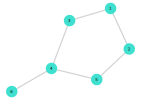


1-tree : [0.0 1.0 1.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 1.0 0.0; 1.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0 1.0 1.0; 0.0 1.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0]


In [15]:
display_S(held_and_karp_2(example))

Lambda_t : [0.16666666666666663, 0.16666666666666663, 0.16666666666666707, 0.16666666666666657, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

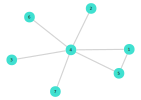

 0.0 0.0 1.0 0.0 0.0 0.0]


In [16]:
display_S(held_and_karp_2(exercise))

## The Held and Karp algorithm - dynamical programming

Whilst column generation based techniques work well on wide graphs, on smaller ones we may want to use a different method.

Here we use dynamical programming to implement the Bellman-Held-Karp algorithm.  
It works well on small graphs, but scales terribly because of its exponential complexity $O(2^n n^2)$ in time (and $O(2^n n)$ in space).

In [ ]:
function dp_held_karp(W,n)
    C = Dict{Tuple{Array,Integer},Integer}()

    for k in collect(2:n)
        C[(Array([k]),k)]= collect(W[1,k])[1]
    end
    
    for s in 2:(n-1), S in collect(combinations(collect(2:n),s)), k in S
        Sp = [s for s in S if (s!=k)]
        C[(S,k)] = collect(typemax(Int64))[1]
        for m in S
            if ( m != k ) && ( C[(S,k)] >= C[(Sp,m)] + W[m,k] )
                C[(S,k)] = C[(Sp,m)] + W[m,k]
            end
        end
    end
    
    opt = Inf
    
    for k in 2:n
        if opt >= C[(collect(2:n),k)] + W[k,1]
            opt = C[(collect(2:n),k)] + W[k,1]
        end
    end
    
    return opt
end

function getPath(W,n,opt)
    println("Valeur optimale : ",opt)
    S = collect(permutations(collect(1:n),n))
    idgood = Integer[]
    Sp = [Integer[]]
    M=Array{Integer,2}[]

    for i in 1:length(S)
        if (sommeTour(W,S[i],opt))
            append!(idgood,i)
        end
    end

    for index in idgood
        if !(matriceAdj(S[index]) in M)
            append!(M,[matriceAdj(S[index])])
            append!(Sp,[S[index]])
        end
    end
    println("Circuits optimaux : ")
    for i in 1:length(Sp)
       if length(Sp[i]) != 0
            println(Sp[i])
        end    
    end
    
    return M
end

function sommeTour(W,L,opt)
    somme = 0
    n = length(L)
    for i in 1:(n-1)
        somme+= W[L[i] ,L[i+1]]
    end
    somme+= W[L[n],L[1]]
    return (somme==opt)
end
function matriceAdj(L)
    n = length(L)
    Madj = zeros(Integer,n,n)
    for i in 1:(n-1)
        Madj[L[i],L[i+1]] = 1
        Madj[L[i+1],L[i]] = 1
    end
    Madj[L[n],L[1]] = 1
    Madj[L[1],L[n]] = 1
    return Madj
end

bellman_held_karp(W) = getPath(W, size(W,1), dp_held_karp(W, size(W,1)))

In [ ]:
for M in bellman_held_karp(example)
    display_S(M)
end

In [ ]:
for M in bellman_held_karp(exercise)
    display_S(M)
end

## Column-generation technique

The master problem is the following

$$ \min \sum_k c_k y_k \ ; \quad y_k \geq 0 \ , \quad \sum_k y_k = 1 \ , \quad \sum -v_{ik} y_k = 0 \quad \forall i \in {2, \ldots, n-1}$$

The subproblem is the following

$$ K(\pi) = \left\{k \ |\ w(\pi) = c_k + \sum_{i=1}^n \pi_n v_{ik} \right\} $$

In [ ]:
function columnGeneration(W)
    
    n = size(W, 1)
    T_List = wheel_like(n)
    m = length(T_List)
    S = 0
    g = complete_graph(n-1)
    
    cr = -1
    while cr < 0
        
        m = length(T_List)
        
        C = [sum(W .* T) for T in T_List]
        D = [sum(T[i,:]) for i in 2:n-1, T in T_List]
        V = D .- 2
        
        ### Master problem
        master = Model(GLPK.Optimizer)
        set_silent(master)
        
        @variable(master, 1 >= Y[1:m] >= 0, Bin)
        
        @objective(master, Min, dot(C, Y))
        
        @constraint(master, convexCombination, sum(Y) == 1)
        
        @constraint(master, averageDegreeTwo[k in 1:n-2], dot(V[k,:], Y) == 0)
        
        optimize!(master)
        
        println(termination_status(master))
        println("obj ", objective_value(master))
        println("Y ", value.(Y))
        #println("C ", C)
        #println("D ", D)
        #println("V ", V)
        S = value.(Y)
        
        θ = shadow_price(convexCombination)
        π = shadow_price.(averageDegreeTwo)
        
        println("θ ", θ)
        println("π ", π)
        
        W_updated = convert.(Float64, W)

        for i in 2:n-1, j in 2:n-1
            W_updated[i,j] -= π[i-1] + π[j-1]
        end

        st = Matrix(adjacency_matrix(Graph(kruskal_mst(g, W_updated[2:n,2:n]))))
        T = zeros(n,n)

        w_tmp = W_updated[1,2:n]
        min_idx_1 = argmin(w_tmp[1:n-1])
        min_idx_2 = argmin(w_tmp[1:n-1 .!= min_idx_1])
        T[1,min_idx_1+1] = 1 ; T[1,min_idx_2+1] = 1 ; T[:,1] .= T[1,:]
        T[2:n,2:n] .= st[1:n-1,1:n-1]
        
        cr = sum(W_updated .* T) - θ - 2*sum(π)
        
        println("cr ", cr)
        
        push!(T_List, T)
        
    end
    
    Tf = zeros(n,n)
    for i in 1:m
        Tf .+= S[i] .* T_List[i]
    end
    
    return Tf
end